In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, UnexpectedAlertPresentException, WebDriverException, TimeoutException, ElementClickInterceptedException, ElementNotInteractableException, InvalidArgumentException, StaleElementReferenceException, SessionNotCreatedException
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.chrome.service import Service
import progressbar as pb
import time 
import pandas as pd
import os
from get_gecko_driver import GetGeckoDriver
from get_chrome_driver import GetChromeDriver
import codecs

from functools import partial
from selenium import webdriver

from multiprocessing import Pool, Process

import os
import stat

import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt

# Analysis


In [2]:
# load data
df = pd.read_excel(".//Dataset for Fig_6_7_8.xlsx")
df.head(5)

,台湾,香港,日本,韩国,美国,荷兰,泰国,新加坡,俄罗斯,url,Province,City/district
0,200,200,200,403,unavailable,403,unavailable,403,unavailable,https://www.ah.gov.cn/,Anhui,Anhui provincial government
1,403,403,403,unavailable,unavailable,unavailable,unavailable,403,403,https://www.hefei.gov.cn/,Anhui,Hefei
2,200,200,200,403,unavailable,403,unavailable,unavailable,unavailable,https://www.fy.gov.cn/,Anhui,Fuyang
3,200,200,200,200,200,200,200,200,200,https://www.ahsz.gov.cn/,Anhui,Suzhou
4,200,200,200,200,200,200,200,200,200,https://www.bozhou.gov.cn/,Anhui,Bozhou


## Geoblocking per province

In [3]:
grouped = df.groupby(["Province", "美国"]).size().unstack(fill_value=0)
grouped

美国,200,202,403,405,412,420,502,504,unavailable
Province,,,,,,,,,
Anhui,3,0,3,0,0,0,0,0,4
Beijing,9,0,0,0,0,0,0,0,1
Chongqing,9,0,0,0,0,0,0,0,1
Fujian,6,0,0,0,0,0,0,0,4
Gansu,7,0,0,0,2,0,0,0,1
Guangdong,10,0,0,0,0,0,0,0,0
Guangxi,2,0,0,0,0,0,0,0,8
Guizhou,0,0,0,0,0,0,0,0,10
Hebei,4,0,0,0,0,0,0,0,6


In [4]:
grouped["pct_geoblocked"] = grouped["403"] / 10 * 100
grouped["pct_unavailable"] = (10 - grouped["200"]) / 10 * 100

result = grouped[["pct_geoblocked", "pct_unavailable"]]
adm_pcode = ["CN034", "CN011", "CN050", "CN035", "CN062",
                       "CN044", "CN045","CN052","CN013","CN023",
                       "CN041","CN042","CN043","CN015","CN032",
                       "CN036","CN022","CN021","CN061","CN037",
                       "CN031","CN014","CN051","CN012","CN065",
             "CN053","CN033"]

result["ADM1_PCODE"] = adm_pcode
result

C:\Users\vbrus\AppData\Local\Temp\ipykernel_15144\1979806314.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["ADM1_PCODE"] = adm_pcode


美国,pct_geoblocked,pct_unavailable,ADM1_PCODE
Province,,,
Anhui,30.0,70.0,CN034
Beijing,0.0,10.0,CN011
Chongqing,0.0,10.0,CN050
Fujian,0.0,40.0,CN035
Gansu,0.0,30.0,CN062
Guangdong,0.0,0.0,CN044
Guangxi,0.0,80.0,CN045
Guizhou,0.0,100.0,CN052
Hebei,0.0,60.0,CN013


In [11]:
import geopandas as gpd
map_data = gpd.read_file('.//geodata//chn_admbnda_adm1_ocha_2020.shp')
map_data.drop(map_data.iloc[26].name,  inplace=True)
map_data

,ADM1_EN,ADM1_ZH,ADM1_PCODE,ADM0_EN,ADM0_ZH,ADM0_PCODE,geometry
0,Shaanxi Province,陕西省,CN061,China,中国,CN,"POLYGON ((109.43453 33.15591, 109.43417 33.153..."
1,Shanghai Municipality,上海市,CN031,China,中国,CN,"MULTIPOLYGON (((121.24731 31.73074, 121.24566 ..."
2,Chongqing Municipality,重庆市,CN050,China,中国,CN,"POLYGON ((109.54600 31.72161, 109.56352 31.718..."
3,Zhejiang Province,浙江省,CN033,China,中国,CN,"MULTIPOLYGON (((120.46805 27.16108, 120.46718 ..."
4,Jiangxi Province,江西省,CN036,China,中国,CN,"POLYGON ((116.53885 26.56975, 116.55643 26.540..."
5,Yunnan Province,云南省,CN053,China,中国,CN,"POLYGON ((105.51205 23.20864, 105.49400 23.230..."
6,Shandong Province,山东省,CN037,China,中国,CN,"MULTIPOLYGON (((120.27662 36.00127, 120.27536 ..."
7,Liaoning Province,辽宁省,CN021,China,中国,CN,"MULTIPOLYGON (((121.42978 39.50441, 121.42695 ..."
8,Tibet Autonomous Region,西藏自治区,CN054,China,中国,CN,"POLYGON ((90.12055 28.17220, 90.11962 28.17022..."
9,Gansu province,甘肃省,CN062,China,中国,CN,"POLYGON ((106.50714 34.22042, 106.55785 34.190..."


In [12]:
merged = map_data.merge(result, left_on = 'ADM1_PCODE', right_on = 'ADM1_PCODE',how = 'outer')
merged.fillna(0, inplace=True)

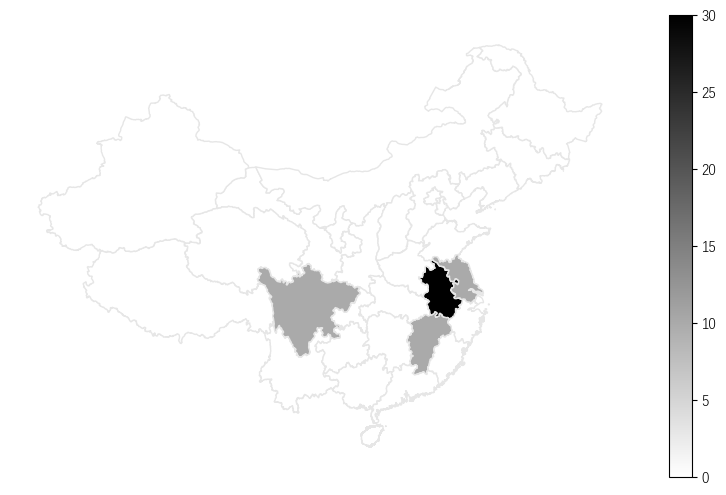

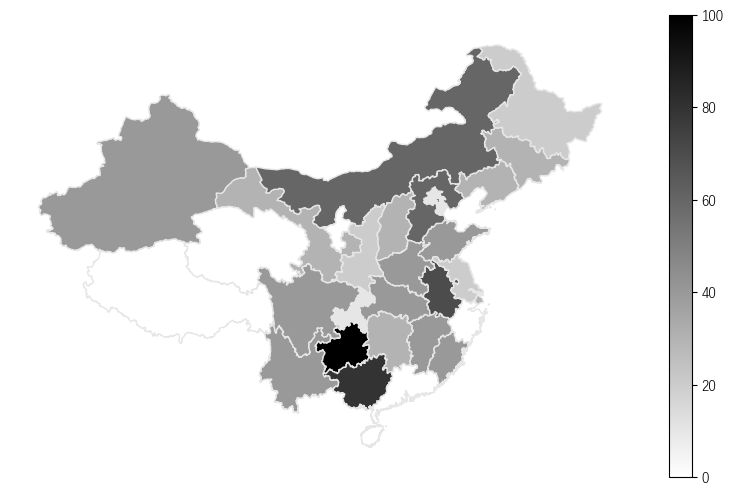

In [13]:
fig, ax = plt.subplots(1, figsize=(10,6))
merged.plot(column='pct_geoblocked', cmap='binary',  linewidth=1, ax=ax, edgecolor='0.9', legend=True,
           legend_kwds={'location': 'right'})
ax.axis('off')
plt.savefig('Fig_6.png', dpi=600)

fig, ax = plt.subplots(1, figsize=(10,6))
merged.plot(column='pct_unavailable', cmap='binary',  linewidth=1, ax=ax, edgecolor='0.9', legend=True,
           legend_kwds={'location': 'right'})
ax.axis('off')
plt.savefig('Fig_7.png', dpi=600)

## Availability by region

In [6]:
# crunch the data into aggregate figures
crunched = pd.DataFrame()

regions = ["台湾", "香港", "日本", "韩国", "美国", "荷兰", "泰国", "新加坡", "俄罗斯"]
regions_en = ["Taiwan", "Hong Kong", "Japan", "South Korea", "United States", "the Netherlands", "Thailand", "Singapore", "Russia"]
for region in regions:
    counts = df.groupby(region).size()
    crunched = pd.concat([crunched, counts], axis=1)
crunched = crunched.set_axis(regions_en, axis=1)
crunched = crunched.transpose()
crunched = crunched.fillna(0)
crunched

,200,202,403,405,412,502,504,unavailable,503,420,500
Taiwan,207.0,1.0,4.0,1.0,5.0,1.0,1.0,50.0,0.0,0.0,0.0
Hong Kong,244.0,1.0,1.0,0.0,4.0,1.0,1.0,17.0,1.0,0.0,0.0
Japan,220.0,1.0,5.0,1.0,5.0,1.0,1.0,36.0,0.0,0.0,0.0
South Korea,199.0,1.0,10.0,0.0,4.0,1.0,1.0,53.0,0.0,1.0,0.0
United States,174.0,1.0,6.0,1.0,4.0,1.0,1.0,81.0,0.0,1.0,0.0
the Netherlands,184.0,1.0,10.0,1.0,4.0,1.0,1.0,67.0,0.0,1.0,0.0
Thailand,169.0,1.0,6.0,1.0,4.0,1.0,1.0,85.0,0.0,1.0,1.0
Singapore,191.0,1.0,7.0,1.0,4.0,1.0,1.0,63.0,0.0,1.0,0.0
Russia,171.0,1.0,5.0,1.0,4.0,1.0,1.0,85.0,0.0,1.0,0.0


In [7]:
# categorization
# takes all 200-range items as "available", all 500-range items as "server error", all 403 as geoblocked, and others as "unavailable"
crunched["available"] = crunched['200'] + crunched['202']
crunched["server error"] = crunched['502'] + crunched['503'] + crunched['500']
crunched["geoblocked"] = crunched['403']
crunched["request time-out"] = crunched['unavailable']
crunched["tester error"] = crunched['405'] + crunched['405'] + crunched['412'] + crunched['420']
data = crunched[["available", "server error", "geoblocked", "request time-out", "tester error"]]
data

,available,server error,geoblocked,request time-out,tester error
Taiwan,208.0,1.0,4.0,50.0,7.0
Hong Kong,245.0,2.0,1.0,17.0,4.0
Japan,221.0,1.0,5.0,36.0,7.0
South Korea,200.0,1.0,10.0,53.0,5.0
United States,175.0,1.0,6.0,81.0,7.0
the Netherlands,185.0,1.0,10.0,67.0,7.0
Thailand,170.0,2.0,6.0,85.0,7.0
Singapore,192.0,1.0,7.0,63.0,7.0
Russia,172.0,1.0,5.0,85.0,7.0


C:\Users\vbrus\AppData\Local\Temp\ipykernel_15144\3514548775.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by='available', ascending=False, inplace=True)


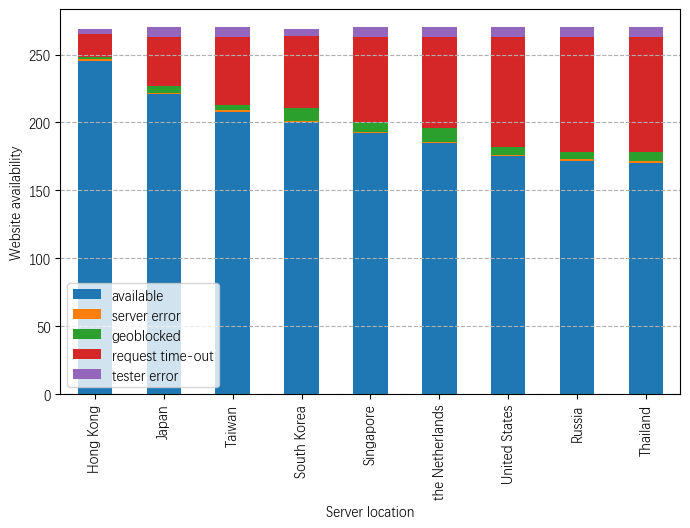

In [8]:
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt

data.sort_values(by='available', ascending=False, inplace=True)
plt.style.use("default")
matplotlib.rcParams['font.family'] = ['DengXian']
matplotlib.rcParams['figure.figsize'] = [8, 5]
data.plot(kind='bar', stacked=True, xlabel='Server location', ylabel='Website availability')
plt.grid(linestyle="dashed", axis='y')
plt.savefig('Fig_8.png', dpi=600)